# AdaptiveBinaryClusteringDelays


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# to install all dependencies use, uncomment the following line and restart the kernel
# %pip install -U -r requirements.txt

# Un/Supervised learning of Temporally Heterogeneous Connections in spiking neurons

**Abstract:** The response of a biological neuron depends on the precise timing of afferent spikes. This temporal aspect of the neuronal code is essential in understanding information processing in neurobiology and applies particularly well to the output of neuromorphic hardware such as event-based cameras. Though, most artificial neuronal models do not take advantage of this minute temporal dimension and here, we develop a model for the efficient detection of temporal spiking motifs based on a layer of neurons with heterogeneous delays. Indeed, the variety of synaptic delays on the dendritic tree allows to synchronize synaptic inputs as they reach the basal dendritic tree. We show this can be formalized as time-invariant logistic regression which can trained using labelled data. We apply this model for solving the specific problem of detecting motion and demonstrate its use by applying it on synthetic naturalistic videos transformed to event-based streams similar to the output of a silicon retina. In particular, we show how its accuracy may evolve as a function of the total computational load. This end-to-end event-based computational brick could help improve the performance of future Spiking Neural Network solutions currently used in neuromorphic chips.


We design a model based on heterosynaptic delays. We will define in the assembly of neurons where each synapse
is defined by a weight *ws* at different delays *τs*. See the following figure: 

In [3]:
datetag = None

In [4]:
datetag = '2022-11-16'

In [5]:
if datetag is None:
    from time import strftime, gmtime
    datetag = strftime("%Y-%m-%d", gmtime())
datetag

'2022-11-16'

In [6]:
import numpy as np
phi = np.sqrt(5)/2 + 1/2
import matplotlib
import matplotlib.pyplot as plt
import torch

import matplotlib
#subplotpars = matplotlib.figure.SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.,)
# subplotpars = matplotlib.figure.SubplotParams(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# subplotpars = matplotlib.figure.SubplotParams(left=0.15, right=.975, bottom=0.175, top=.975)
# subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975)
#subplotpars = matplotlib.figure.SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.,)
# subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.87)

subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975)

In [7]:
figpath = None

In [8]:
from dataclasses import dataclass, asdict

@dataclass
class Params:
    datetag: str = datetag
    N_pre: int = 256 # number of presynaptic inputs
    N_PG_time: int = 75 # number of timesteps in PG, must be a odd number for convolutions
    N_PGs: int = 35 # number of polychronous groups
    E_PG: float = 10. # excitability range of PGs
    p_PG: float = .001# ratio of non-zero coefficients in PGs
    tau_decay: float = 2.# time constant for synchrony

    ## Raster plots
    N_time: int = 1000# number of timesteps for the raster plot
    N_trials: int = 10# number of trials
    p_B: int = .001# prior probability of firing for postsynaptic raster plot
    p_A: int = .01# prior probability of firing for presynaptic raster plot
    seed: int = 42# seed

    ## figures
    verbose: bool = False# Displays more verbose output.
    fig_width: float = 12# width of figure
    phi: float = 1.61803# beauty is gold
    N_PG_show: float = 5# number of PG to show in plot_PG



In [9]:
opt = Params()
opt

Params(datetag='2022-11-16', N_pre=256, N_PG_time=75, N_PGs=35, E_PG=10.0, p_PG=0.001, tau_decay=2.0, N_time=1000, N_trials=10, p_B=0.001, p_A=0.01, seed=42, verbose=False, fig_width=12, phi=1.61803, N_PG_show=5)

### generative & inference models for polychronous groups

In [10]:
@dataclass
class ABCD:
    opt: Params = opt
    d = asdict(opt)

    def set_PG(self, seed=None, seed_offset=0):
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        # define PGs as matrices to be used as kernels
        PG = self.opt.E_PG * torch.randn(self.opt.N_pre, self.opt.N_PGs, self.opt.N_PG_time)
        #threshold = torch.abs(PG).quantile(1-self.opt.p_PG)
        # TODO : get analytically
        from scipy.stats import norm
        threshold = self.opt.E_PG * norm.ppf(1-self.opt.p_PG)
        PG *= (torch.abs(PG) > threshold) # zero out everything below the threshold
        return PG

    def get_b(self, seed=None, seed_offset=1):
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        # draw causes (PGs)
        # as a matrix of sparse PG activations
        # todo: make something more complex that a binary activation
        b_proba = torch.ones(self.opt.N_trials, self.opt.N_PGs, self.opt.N_time)*self.opt.p_B
        return torch.bernoulli(b_proba)

    def plot_b(self, b, trial_nb = 0, cmap='binary'):
        fig, ax = plt.subplots(1, 1, figsize=(self.opt.fig_width, self.opt.fig_width/self.opt.phi))
        ax.imshow(b[trial_nb, ...].numpy(), cmap=cmap, interpolation='none')
        ax.set_ylabel('@post')
        ax.set_xlabel('time')
        return fig, ax

    def model_a(self, b, PG):
        # draws the probability of firing for each presynaptic address over time
        # input b -> postsynaptic raster plot
        #       PG -> polychronous groups spatio temporal kernels
        #       p_A -> prior proba of firing for the presynaptic addresses
        logit_p_A = torch.logit(torch.tensor(self.opt.p_A))
        return torch.sigmoid(logit_p_A + torch.conv1d(b*1., PG, padding=self.opt.N_PG_time//2))

    def draw_a(self, b, PG, seed=None, seed_offset=2):
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        # generate the corresponding raster plot
        a_proba = self.model_a(b, PG)
        return torch.bernoulli(a_proba)

    def plot_a(self, a, trial_nb = 0, cmap = 'binary', subplotpars=subplotpars):
        fig, ax = plt.subplots(2, 1, figsize=(self.opt.fig_width, self.opt.fig_width/self.opt.phi))
        ax[0].matshow(a[trial_nb, ...].numpy(), cmap=cmap, interpolation='none')
        ax[0].set_ylabel('Synapse')
        ax[0].set_xlabel('Time')
        ax[1].step(np.arange(self.opt.N_pre), a.numpy().mean(axis=(0, 2)), label='firing rate')
        ax[1].hlines(self.opt.p_A, 0, self.opt.N_pre, linestyles='--', color='orange', label='probability of firing for each address')
        ax[1].set_xlabel('address')
        ax[1].set_ylim(0)
        ax[1].legend()
        return fig, ax

    def inference_with_PGs(self, a, b, PG):
        # infer 
        b_hat = torch.conv_transpose1d(a*1., PG, padding=self.opt.N_PG_time//2)
        # decision
        p_B = b.sum()/(self.opt.N_trials*self.opt.N_PGs*self.opt.N_time) # ça suppose qu'on connait b.sum()...
        b_threshold = torch.quantile(b_hat, 1-p_B)
        b_hat_bin = (b_hat>b_threshold)
        return b_hat, b_hat_bin

    def generative_model(self, seed=None, seed_offset=3):
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        PG, b = self.set_PG(seed=seed), self.get_b(seed=seed+1)
        a = self.draw_a(b, PG, seed=seed+2)
        return a, b, PG


    def test_model(self, PG, PG_true=None, seed=None, seed_offset=4):
        if seed is None: seed = self.opt.seed + seed_offset
        torch.manual_seed(seed)
        if PG_true is None: PG_true = PG
        # define PGs
        # draw causes (PGs)
        b = self.get_b(seed=seed)
        # generate the corresponding raster plot
        a = self.draw_a(b, PG_true, seed=seed+1)
        # infer 
        b_hat, b_hat_bin = self.inference_with_PGs(a, b, PG)
        return torch.mean((b_hat_bin == b)*1.), torch.mean(b_hat_bin[b==1]*1.), 1-torch.mean(b_hat_bin[b==0]*1.)

    def plot_PG(self, PG, cmap='seismic', colors=None, aspect=None, figsize=None, subplotpars=subplotpars):

        if PG.dtype == torch.bool:
            PG_max = 1
            PG_min = 0
            cmap = 'binary'
        else:
            #PG = PG.numpy()
            PG_max = np.abs(PG).max().item()
            PG_min = -PG_max

        if figsize is None:
            figsize = (self.opt.fig_width, self.opt.fig_width/self.opt.phi)

        fig, axs = plt.subplots(1, self.opt.N_PG_show, figsize=figsize, subplotpars=subplotpars)
        for i_PG in range(self.opt.N_PG_show):
            ax = axs[i_PG]
            ax.set_axisbelow(True)

            for i in range(PG.shape[0]):
                ax.scatter(y=i*np.ones((self.opt.N_PG_time,)), 
                           x=np.arange(self.opt.N_PG_time), 
                           s=np.abs(PG[i, i_PG, :]), c='k', #PG[i, i_PG, :], 
                           alpha=.8, cmap=cmap)
            ax.set_xlim(0, PG.shape[2])
            #ax.imshow(PG[:, i_PG, :], cmap=cmap, vmin=PG_min, vmax=PG_max, interpolation='none')
            ax.set_xlabel('Delay')
            ax.set_title(f'PG #{i_PG+1}', color='k' if colors is None else colors[i_PG])
            if not aspect is None: ax.set_aspect(aspect)

            ax.set_ylim(-.5, self.opt.N_pre-.5)
            ax.set_yticks(np.arange(0, self.opt.N_pre, 1))
            ax.set_yticklabels(np.arange(0, self.opt.N_pre, 1)+1)
            if i_PG>0: ax.set_yticklabels([])

            for side in ['top', 'right']: ax.spines[side].set_visible(False)
            ax.set_xticks([0, self.opt.N_PG_time//2, self.opt.N_PG_time-1])
            ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(self.opt.N_PG_time//4))
            #ax.xaxis.set_minor_locator(AutoMinorLocator(4))
            #ax.set_xticklabels([-(self.opt.N_PG_time//2), 0, self.opt.N_PG_time//2])
            ax.set_xticklabels([0, (self.opt.N_PG_time//2), (self.opt.N_PG_time)])
            ax.grid(True, axis='y', linestyle='-', lw=1)
            ax.grid(True, axis='x', which='both', linestyle='-', lw=.1)

        axs[0].set_ylabel('Synapse')
        return fig, axs

    def plot_inference(self, b, b_hat, b_hat_bin, trial_nb = 0, t_min = 100, t_max = 150, subplotpars=subplotpars):
        fig, ax = plt.subplots(1, 3, figsize=(self.opt.fig_width, self.opt.fig_width), subplotpars=subplotpars)
        ax[2].imshow(b_hat_bin[trial_nb, :, t_min:t_max])
        ax[0].imshow(b[trial_nb, :, t_min:t_max])
        ax[1].imshow(b_hat[trial_nb, :, t_min:t_max])
        return fig, ax

    def plot_inference_histo(self, b_hat, nb_bins = 100):
        fig, ax = plt.subplots(1, 1, figsize=(self.opt.fig_width, self.opt.fig_width/self.opt.phi))
        ax.hist(b_hat.numpy().ravel(), bins=nb_bins)
        ax.set_ylabel('smarts')
        ax.set_xlabel('value of b_hat')
        ax.set_yscale('log')
        return fig, ax


In [11]:
def printfig(fig, name, ext='pdf', figpath=figpath):
    dpi_exp = None
    bbox = 'tight'
    fig.savefig(os.path.join(figpath, name + '.' + ext), dpi = dpi_exp, bbox_inches=bbox, transparent=True)

In [12]:
env = ABCD(opt)

In [13]:
env.opt, env.d

(Params(datetag='2022-11-16', N_pre=256, N_PG_time=75, N_PGs=35, E_PG=10.0, p_PG=0.001, tau_decay=2.0, N_time=1000, N_trials=10, p_B=0.001, p_A=0.01, seed=42, verbose=False, fig_width=12, phi=1.61803, N_PG_show=5),
 {'datetag': '2022-11-16',
  'N_pre': 256,
  'N_PG_time': 75,
  'N_PGs': 35,
  'E_PG': 10.0,
  'p_PG': 0.001,
  'tau_decay': 2.0,
  'N_time': 1000,
  'N_trials': 10,
  'p_B': 0.001,
  'p_A': 0.01,
  'seed': 42,
  'verbose': False,
  'fig_width': 12,
  'phi': 1.61803,
  'N_PG_show': 5})

#### dev sandox

In [14]:
env = ABCD(opt)
a, b, PG = env.generative_model()

In [15]:
PG.shape

torch.Size([256, 35, 75])

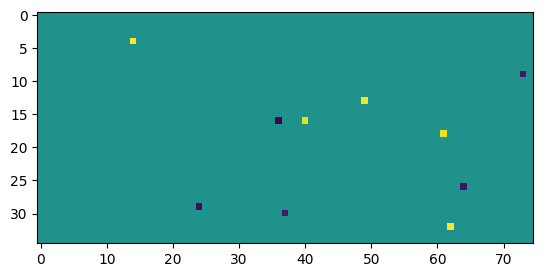

In [16]:
plt.imshow(PG[0, :, :])

# generative model for polychronous groups

In [17]:
opt = Params()
env = ABCD(opt)
a, b, PG = env.generative_model()
# env.plot_PG(PG);
# TODO find a better rule to generate PGs

Draw one instance of single PGs:

In [18]:
logit_p_A = torch.logit(torch.tensor(opt.p_A));
rp_PG = torch.sigmoid(logit_p_A + PG) > torch.rand(opt.N_pre, opt.N_PGs, opt.N_PG_time)
#env.plot_PG(rp_PG);

Draw the occurrences of PGs:

(<Figure size 1200x741.643 with 1 Axes>,
 <AxesSubplot: xlabel='time', ylabel='@post'>)

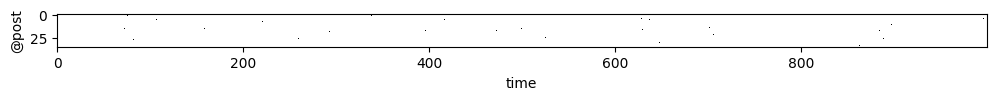

In [19]:
env.plot_b(b, trial_nb = 2)

Resulting raster plot:

(<Figure size 1200x741.643 with 2 Axes>,
 array([<AxesSubplot: xlabel='Time', ylabel='Synapse'>,
        <AxesSubplot: xlabel='address'>], dtype=object))

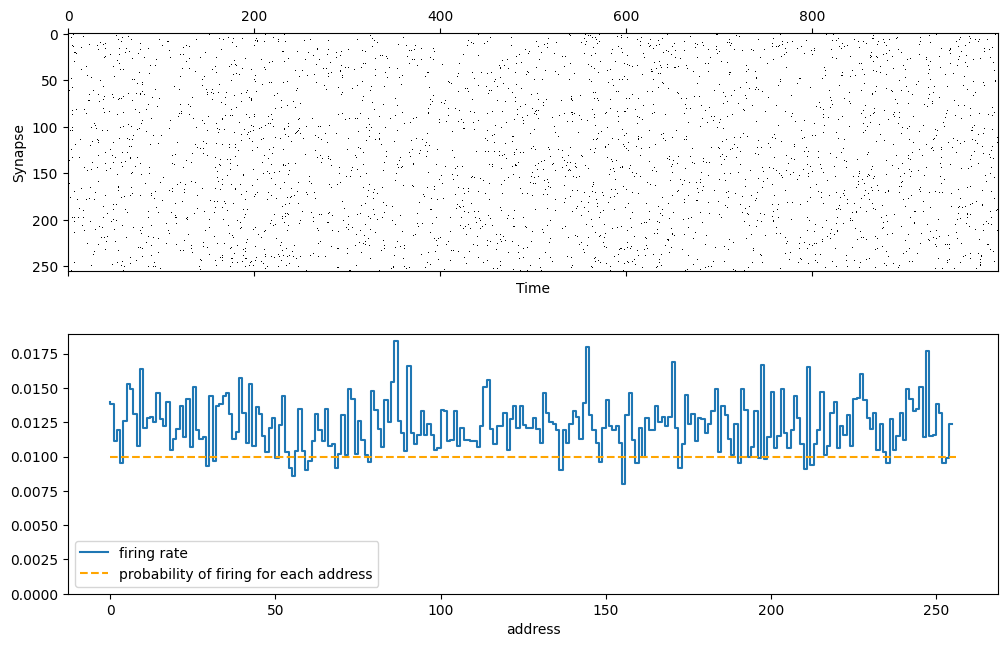

In [20]:
env.plot_a(a, trial_nb = 7)
# TODO correct this firing rate

# inference model for polychronous groups

knowing the raster plot `a`, let's try to infer `b` :

(<Figure size 1200x741.643 with 1 Axes>,
 <AxesSubplot: xlabel='value of b_hat', ylabel='smarts'>)

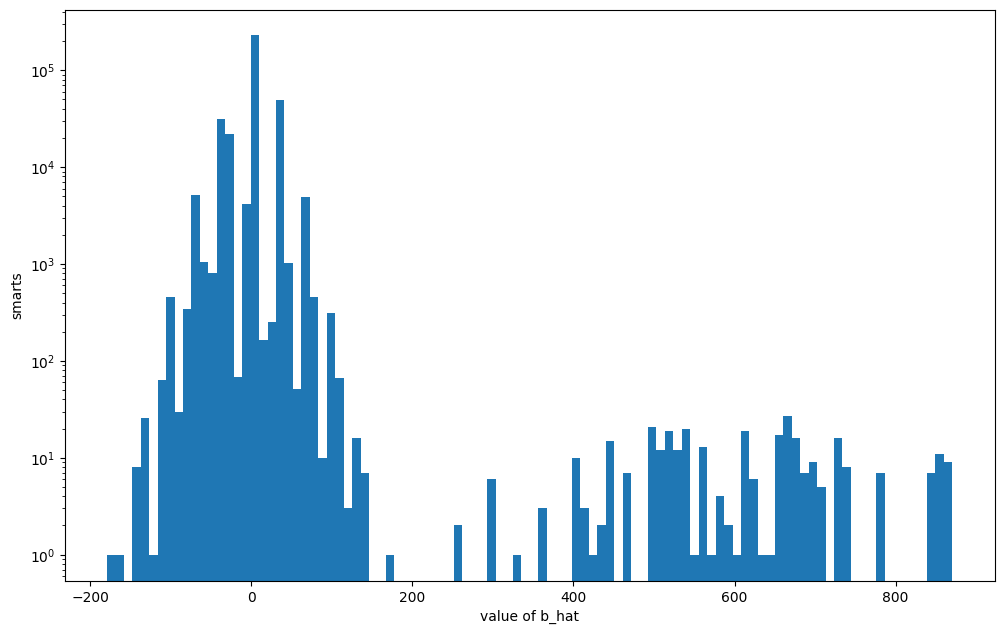

In [21]:
b_hat, b_hat_bin = env.inference_with_PGs(a, b, PG)
env.plot_inference_histo(b_hat)

(<Figure size 1200x1200 with 3 Axes>,
 array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >], dtype=object))

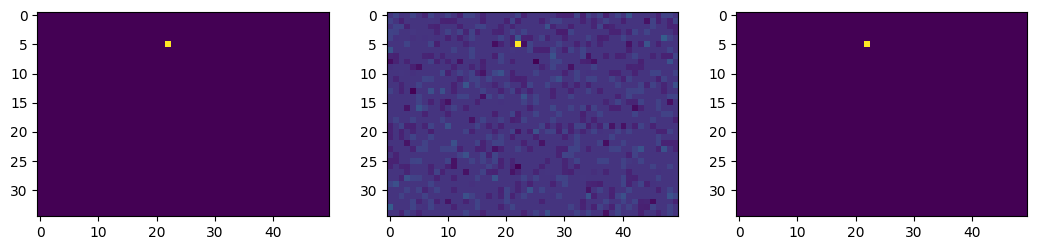

In [22]:
env.plot_inference(b, b_hat, b_hat_bin)

## test model, learning 

In [23]:
%%timeit
accuracy, TP, TN = env.test_model(PG, PG)

254 ms ± 4.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
accuracy, TP, TN = env.test_model(PG, PG)
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=100.00%, TP=100.00%, TN=100.00%


## Figure 1

In [34]:
N_PGs = 5
opt_fig1 = Params(  datetag = datetag + '_fig1',
                    N_pre = 10, 
                    N_PGs = N_PGs,
                    N_PG_time = 71,
                    p_PG = .07,
                    p_A = 0.0015,
                    p_B = 0.0015,
                    N_PG_show = N_PGs,
                    N_trials = 1,
                    N_time = 240,
                    seed = 2373,
                    fig_width = 4.5
                    )
env_fig1 = ABCD(opt_fig1)
a, b, PG = env_fig1.generative_model()

In [35]:
opt_fig1, env_fig1.opt, env_fig1.opt.N_PGs

(Params(datetag='2022-11-16_fig1', N_pre=10, N_PG_time=71, N_PGs=5, E_PG=10.0, p_PG=0.07, tau_decay=2.0, N_time=240, N_trials=1, p_B=0.0015, p_A=0.0015, seed=2373, verbose=False, fig_width=4.5, phi=1.61803, N_PG_show=5),
 Params(datetag='2022-11-16_fig1', N_pre=10, N_PG_time=71, N_PGs=5, E_PG=10.0, p_PG=0.07, tau_decay=2.0, N_time=240, N_trials=1, p_B=0.0015, p_A=0.0015, seed=2373, verbose=False, fig_width=4.5, phi=1.61803, N_PG_show=5),
 5)

In [36]:
env_fig1.opt.N_pre, env_fig1.opt.N_PGs, env_fig1.opt.N_PG_time

(10, 5, 71)

In [37]:
figsize = (env_fig1.opt.fig_width, env_fig1.opt.fig_width/2.5)
subplotpars_fig1 = matplotlib.figure.SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.,)
colors = ['r', 'g' , 'b' , 'm', 'k']
env_fig1 = ABCD(opt_fig1)
a, b, PG = env_fig1.generative_model()

In [38]:
#b[0, 3, 350] = True
#b[0, 2, 350] = True
#b[0, 1, 150] = True
b[0, 0, 50] = True
#b[0, 3, 180] = True
#b[0, 3, 42] = True
b[0, 1, 201] = True
b[0, 1, 114] = True
b[0, 2, 42] = True
b[0, 2, 104] = True
#b[0, 0, 50] = True
b.shape

torch.Size([1, 5, 240])

/var/folders/3p/m0g52j9j69z3gj8ktpgg1dm00000gn/T/ipykernel_40761/948331184.py:111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(y=i*np.ones((self.opt.N_PG_time,)),


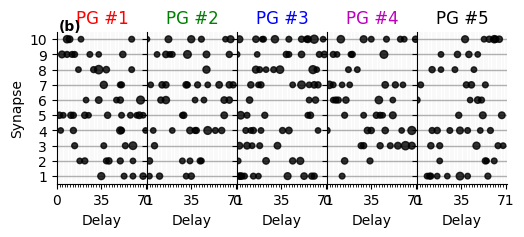

In [39]:
fig, axs = env_fig1.plot_PG(torch.relu(PG), cmap='Reds', aspect=12, colors=colors, figsize=figsize, subplotpars=subplotpars_fig1)
fig.text(0.03, 0.95,'(b)', horizontalalignment='center', verticalalignment='center', weight='bold')
if not figpath is  None: fig.savefig(figpath + '/figure_1b.pdf') # TODO use printfig
plt.show()

Then from the following raster plot, each PG described if the figure above will be selective to the spatio-temporal pattern of the same color: 

In [40]:
%pwd

'/Users/laurentperrinet/metagit/ABCD/2022-11-23_cosyne-THC/dev'

In [41]:
colors, env_fig1.opt.N_PGs, colors[:env_fig1.opt.N_PGs]

(['r', 'g', 'b', 'm', 'k'], 5, ['r', 'g', 'b', 'm', 'k'])

[Text(0, 0, '1'),
 Text(0, 1, '2'),
 Text(0, 2, '3'),
 Text(0, 3, '4'),
 Text(0, 4, '5')]

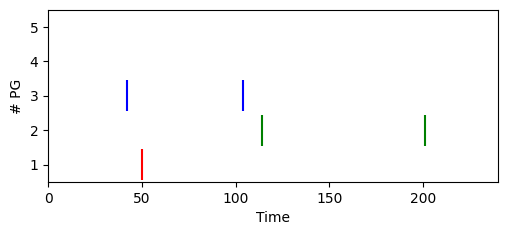

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(env_fig1.opt.fig_width, env_fig1.opt.fig_width/(phi+1)), subplotpars=subplotpars_fig1)
ax.eventplot([np.where(b[0, i, :] == 1.)[0] for i in range(0, env_fig1.opt.N_PGs)], 
              colors=colors, lineoffsets=1, linelengths=0.9);
ax.set_ylabel('# PG')
ax.set_xlabel('Time')
ax.set_xlim(0, env_fig1.opt.N_time)
ax.set_ylim(-.5, env_fig1.opt.N_PGs-.5)
ax.set_yticks(np.arange(0, env_fig1.opt.N_PGs))
ax.set_yticklabels(np.arange(0, env_fig1.opt.N_PGs)+1)
#if not figpath is  None: fig.savefig(figpath + '/figure_1b.pdf')

It results in the following activation of the postsynaptic neurons (activation probability with a Bernoullin trial):

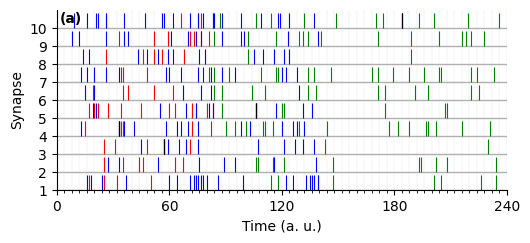

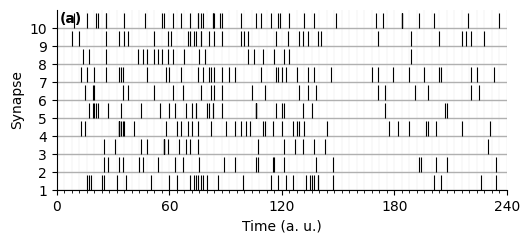

In [43]:
for suff in ['', '_k']:
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplotpars=subplotpars_fig1)
    for i_PG in range(env_fig1.opt.N_PGs):
        b_ = torch.zeros_like(b)
        b_[0, i_PG, :] = b[0, i_PG, :]
        a_ = env_fig1.draw_a(b_, PG)
        #ax.eventplot([np.where(a_[0, i, :] == 1.)[0] for i in range(0, env_fig1.opt.N_pre)], 
        #              colors=colors[i_PG] if suff=='' else 'k', 
        #              lineoffsets=1, linelengths=0.9, linewidths=1);
        for i in range(0, env_fig1.opt.N_pre):
            ax.eventplot(np.where(a_[0, i, :] == 1.)[0], colors=colors[i_PG] if suff=='' else 'k', 
                         lineoffsets=1.*i+.4, linelengths=0.8, linewidths=0.8);

    # TODO : report these in the code above
    ax.set_ylabel('Synapse')
    ax.set_xlabel('Time (a. u.)')
    ax.set_xlim(0, env_fig1.opt.N_time)
    ax.set_ylim(0, env_fig1.opt.N_pre)
    ax.set_yticks(np.arange(0, env_fig1.opt.N_pre, 1))
    ax.set_yticklabels(np.arange(0, env_fig1.opt.N_pre, 1)+1)
    for side in ['top', 'right']: ax.spines[side].set_visible(False)
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(4))
    ax.set_xticks(np.arange(0, env_fig1.opt.N_time+1, 60))
    ax.set_xticklabels(np.arange(0, env_fig1.opt.N_time+1, 60))
    ax.grid(True, axis='y', linestyle='-', lw=1)
    ax.grid(True, axis='x', which='both', linestyle='-', lw=.1)
    
    fig.text(0.03, 0.95,'(a)', horizontalalignment='center', verticalalignment='center', weight='bold')

    if not figpath is  None: fig.savefig(figpath + '/figure_1a' + suff + '.pdf') # TODO use printfig
    plt.show()

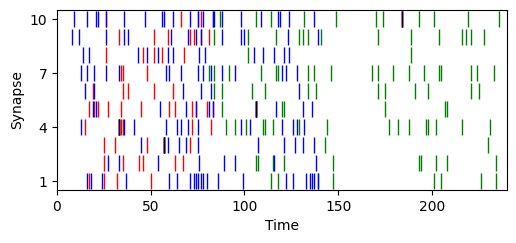

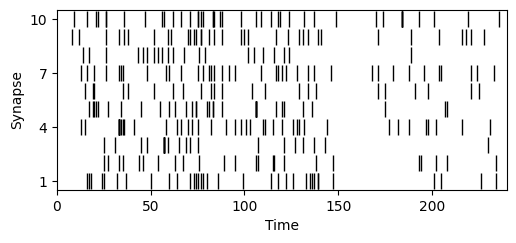

In [44]:
for suff in ['', '_k']:
    fig, ax = plt.subplots(1, 1, figsize=(env_fig1.opt.fig_width, env_fig1.opt.fig_width/2.5), subplotpars=subplotpars_fig1)
    for i_PG in range(env_fig1.opt.N_PGs):
        b_ = torch.zeros_like(b)
        b_[0, i_PG, :] = b[0, i_PG, :]
        a_ = env_fig1.draw_a(b_, PG)
        ax.eventplot([np.where(a_[0, i, :] == 1.)[0] for i in range(0, env_fig1.opt.N_pre)], 
                      colors=colors[i_PG] if suff=='' else 'k', 
                      lineoffsets=1, linelengths=0.9, linewidths=1);
    ax.set_ylabel('Synapse')
    ax.set_xlabel('Time')
    ax.set_xlim(0, env_fig1.opt.N_time)
    ax.set_ylim(-.5, env_fig1.opt.N_pre-.5)
    ax.set_yticks(np.arange(0, env_fig1.opt.N_pre, 3))
    ax.set_yticklabels(np.arange(0, env_fig1.opt.N_pre, 3)+1)
    #if not figpath is  None: fig.savefig(figpath + '/figure_1a' + suff + '.pdf')
    plt.show()

/var/folders/3p/m0g52j9j69z3gj8ktpgg1dm00000gn/T/ipykernel_40761/948331184.py:111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(y=i*np.ones((self.opt.N_PG_time,)),


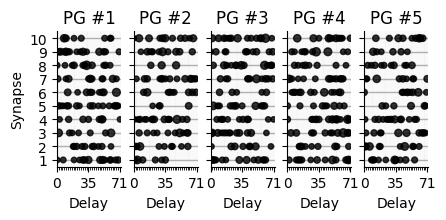

In [45]:
fig, axs = env_fig1.plot_PG(PG, aspect=15)
#if not figpath is  None: fig.savefig(figpath + '/figure_1c.pdf')
plt.show()

In [46]:
# logit_p_A = torch.logit(torch.tensor(opt.p_A));
# rp_PG = torch.sigmoid(logit_p_A + PG) > torch.rand(opt.N_pre, opt.N_PGs, opt.N_PG_time)
# fig, axs = env_fig1.plot_PG(rp_PG, aspect=15);

In [47]:
env_fig1.opt.N_PGs

5

In [48]:
i

9

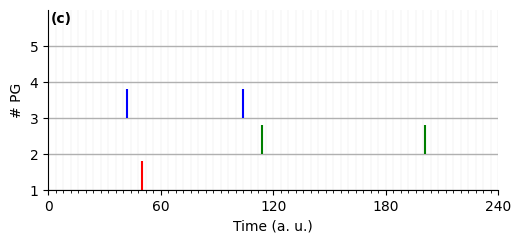

In [49]:
fig, ax = plt.subplots(1, 1, figsize=figsize, subplotpars=subplotpars_fig1)

for i in range(0, env_fig1.opt.N_PGs):
    ax.eventplot([np.where(b[0, i, :] == 1.)[0]], colors=colors[i], lineoffsets=1.*i+.4, linelengths=0.8);

ax.set_ylabel('# PG')
ax.set_xlabel('Time (a. u.)')
ax.set_xlim(0, env_fig1.opt.N_time)
ax.set_ylim(0, env_fig1.opt.N_PGs)

ax.set_yticks(np.arange(0, env_fig1.opt.N_PGs))
ax.set_yticklabels(np.arange(0, env_fig1.opt.N_PGs)+1)
for side in ['top', 'right']: ax.spines[side].set_visible(False)
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(4))
ax.set_xticks(np.arange(0, env_fig1.opt.N_time+1, 60))
ax.set_xticklabels(np.arange(0, env_fig1.opt.N_time+1, 60))
ax.grid(True, axis='y', linestyle='-', lw=1)
ax.grid(True, axis='x', which='both', linestyle='-', lw=.1)

fig.text(0.03, 0.95,'(c)', horizontalalignment='center', verticalalignment='center', weight='bold')

if not figpath is  None: fig.savefig(figpath + '/figure_1c.pdf') # TODO use printfig

TODO: montrer des PGs générant des vagues, du bruit de Poisson, des one-spike per neuron, ...

## scanning parameters

In [41]:
%mkdir -p data_cache

In [42]:
opt.datetag

'2022-11-16'

In [43]:
%ls data_cache/{opt.datetag}_scan_*.json

zsh:1: no matches found: data_cache/2022-11-16_scan_*.json


In [44]:
new_env = ABCD(opt)

In [45]:
scan_dicts= {'N_PGs' : [8, 13, 21, 34, 55, 89, 144, 233, 377, 610], #, 987, 1364, 2351],
             'N_PG_time' : [1, 3, 7, 15, 31, 63, 127, 255, 511],
             'N_pre' : [8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1364, 2351],
            }

label_dicts= {'N_PGs' : 'number of PGs',
             'N_PG_time' : 'duration of PGs',
             'N_pre' : 'number of presynaptic inputs',
            }
import os
import time
import pandas as pd
import numpy as np

N_cv = 10
seed = np.random.randint(1000)
verb = False

for key in scan_dicts:
    filename = f'data_cache/{opt.datetag}_scan_{key}.json'
    print(f'{filename=}')
    if os.path.isfile(filename):
        df_scan = pd.read_json(filename)
    else:
        measure_columns = [key, 'accuracy', 'TP', 'TN', 'time']
        df_scan = pd.DataFrame([], columns=measure_columns)
        i_loc = 0
        for i_value, value in enumerate(scan_dicts[key]):
            if verb: print('i_value', i_value + 1, ' /', len(scan_dicts[key]), end='\t')

            for i_cv in  range(N_cv):
                # tic
                since = time.time()
                # make a new model
                new_env = ABCD(opt)
                print(key, value)
                new_env.d[key] = value
                # draw a new set of PGs
                PG = new_env.set_PG(seed=seed+i_loc)
                # test it
                accuracy, TP, TN = new_env.test_model(PG, PG, seed=seed+i_loc)
                # toc
                elapsed_time = time.time() - since
                df_scan.loc[i_loc] = {key:value, 'accuracy':accuracy.item(), 'TP':TP.item(), 'TN':TN.item(), 'time':elapsed_time}
                i_loc += 1

                if verb: print(f" - One pass completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

        df_scan.to_json(filename)
    print(df_scan)

filename='data_cache/2022-11-16_scan_N_PGs.json'
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 8
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 13
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 21
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 34
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 55
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 89
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 144
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 233
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 377
N_PGs 610
N_PGs 610
N_PGs 610
N_PGs 610
N_PGs 610
N_PGs 610
N_PGs 610
N_PGs 610
N_PGs 610
N_PGs 610
    N_PGs  accuracy  

    N_PGs  accuracy        TP        TN      time
0       8  1.000000  1.000000  1.000000  0.281858
1       8  0.999994  0.997151  0.999997  0.258399
2       8  0.999994  0.996805  0.999997  0.248928
3       8  0.999994  0.996894  0.999997  0.260371
4       8  1.000000  1.000000  1.000000  0.244901
..    ...       ...       ...       ...       ...
95    610  1.000000  1.000000  1.000000  0.247092
96    610  1.000000  1.000000  1.000000  0.251252
97    610  1.000000  1.000000  1.000000  0.251143
98    610  1.000000  1.000000  1.000000  0.255949
99    610  1.000000  1.000000  1.000000  0.268582

[100 rows x 5 columns]


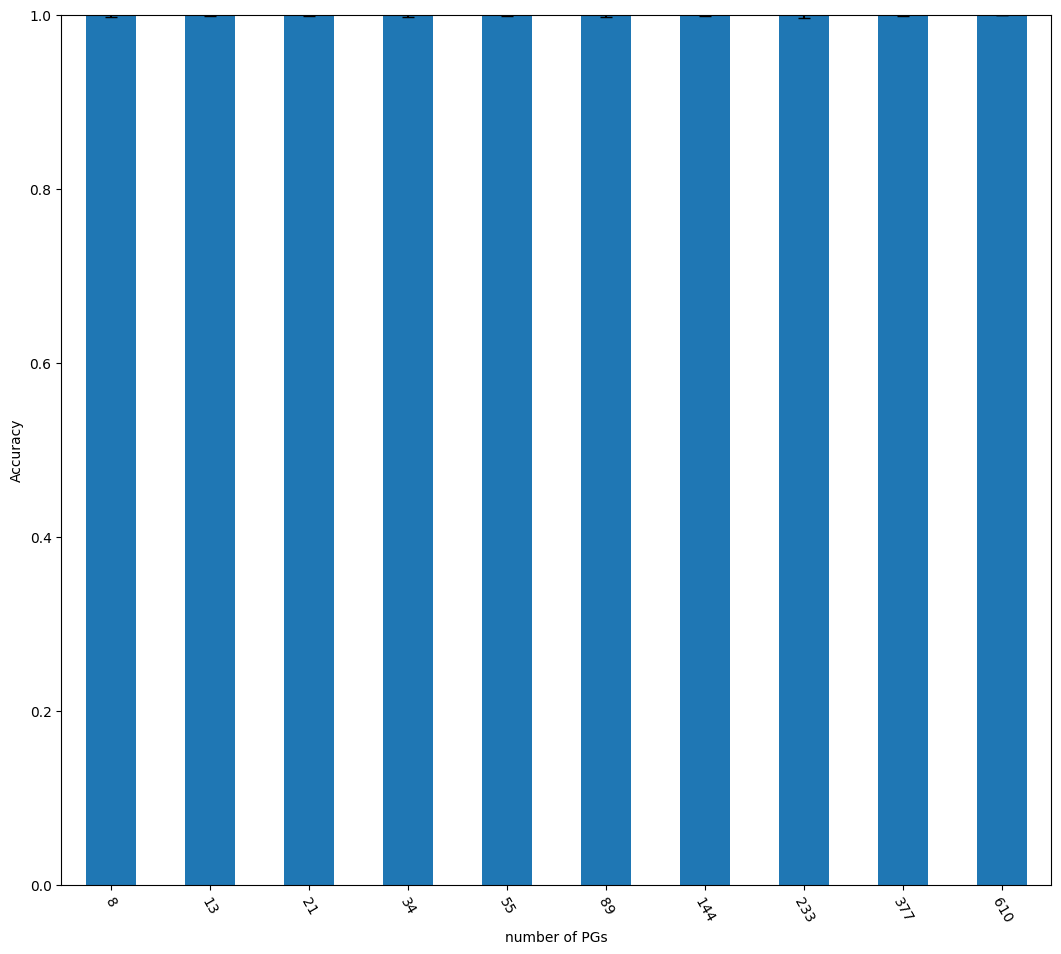

    N_PG_time  accuracy        TP        TN      time
0           1  1.000000  1.000000  1.000000  0.251310
1           1  0.999994  0.997151  0.999997  0.262417
2           1  0.999994  0.996805  0.999997  0.252699
3           1  0.999994  0.996894  0.999997  0.246907
4           1  1.000000  1.000000  1.000000  0.247482
..        ...       ...       ...       ...       ...
85        511  1.000000  1.000000  1.000000  0.244591
86        511  1.000000  1.000000  1.000000  0.245377
87        511  1.000000  1.000000  1.000000  0.245068
88        511  1.000000  1.000000  1.000000  0.254466
89        511  1.000000  1.000000  1.000000  0.250477

[90 rows x 5 columns]


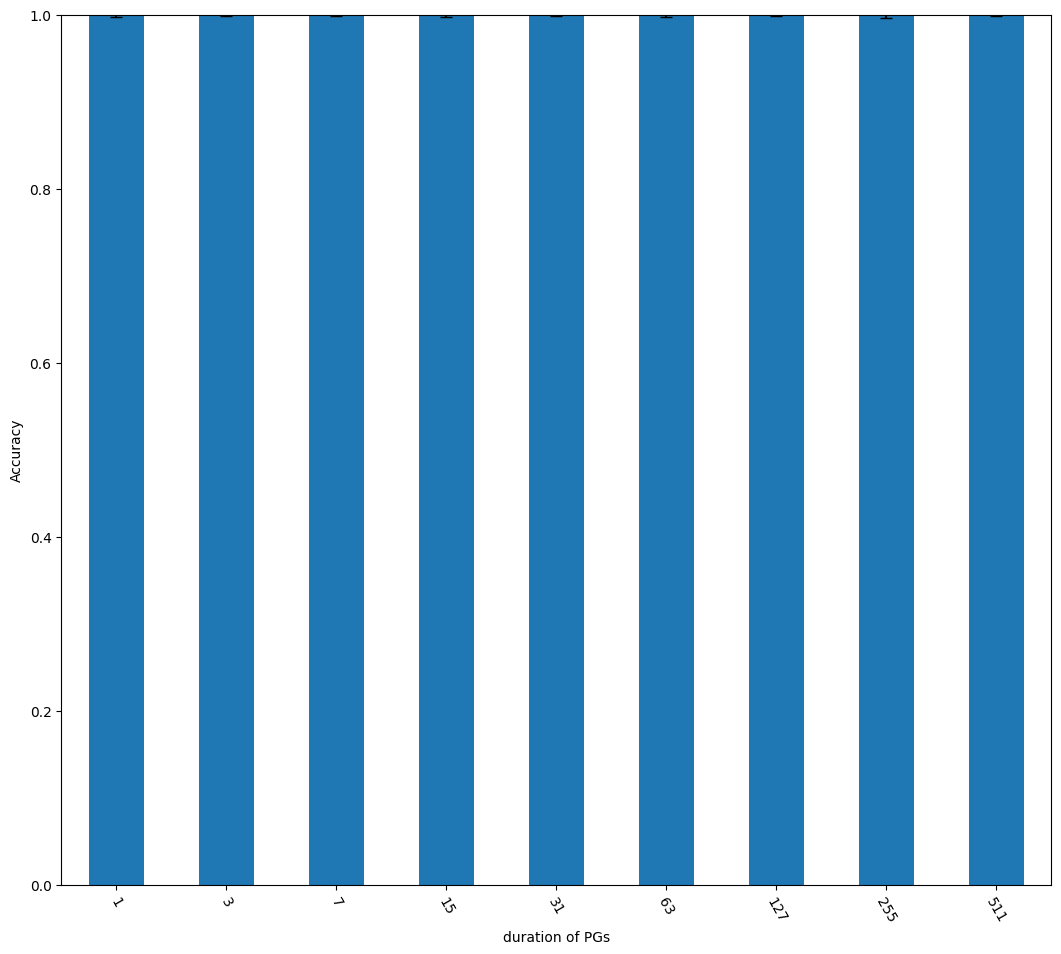

     N_pre  accuracy        TP        TN      time
0        8  1.000000  1.000000  1.000000  0.249004
1        8  0.999994  0.997151  0.999997  0.244245
2        8  0.999994  0.996805  0.999997  0.244401
3        8  0.999994  0.996894  0.999997  0.238029
4        8  1.000000  1.000000  1.000000  0.238083
..     ...       ...       ...       ...       ...
125   2351  1.000000  1.000000  1.000000  0.283033
126   2351  1.000000  1.000000  1.000000  0.250532
127   2351  1.000000  1.000000  1.000000  0.253783
128   2351  0.999994  0.997143  0.999997  0.249890
129   2351  1.000000  1.000000  1.000000  0.248969

[130 rows x 5 columns]


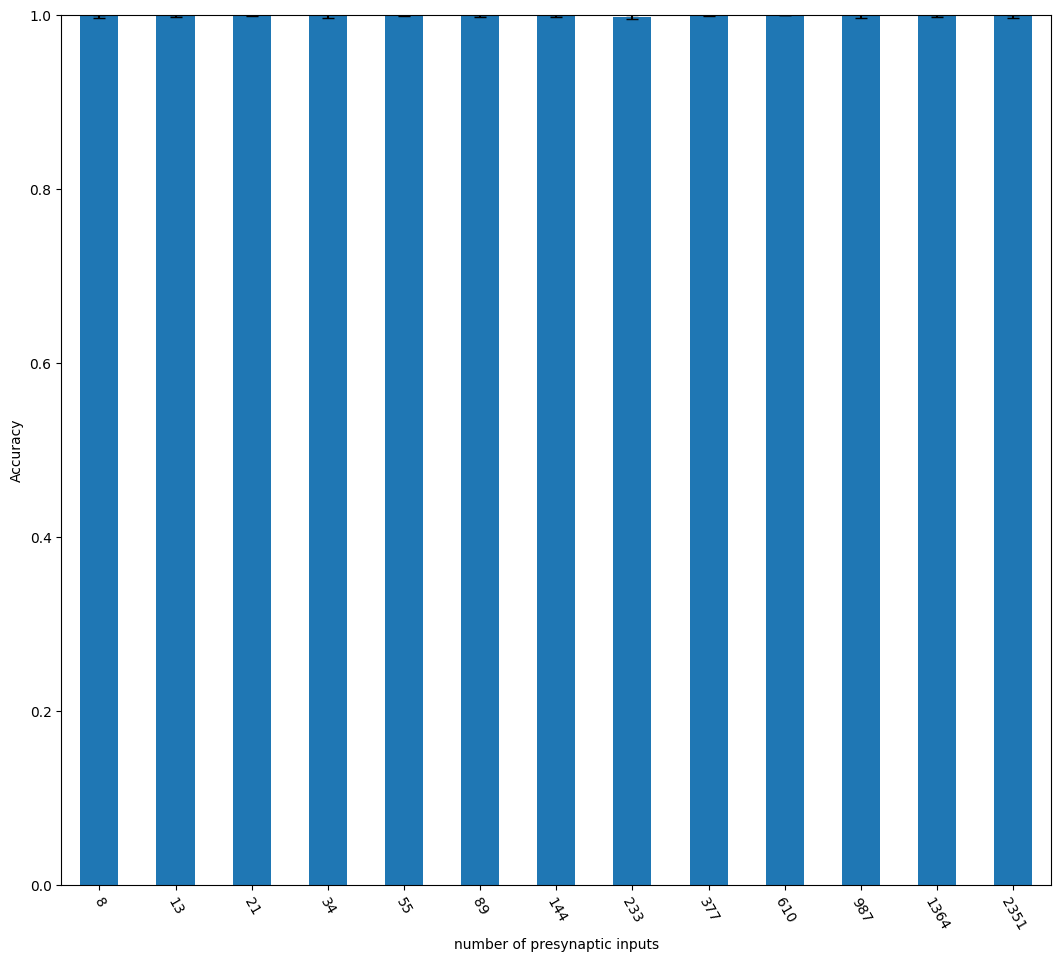

In [46]:

import matplotlib.pyplot as plt
for key in scan_dicts:
    filename = f'data_cache/{datetag}_scan_{key}.json'
    df_scan = pd.read_json(filename)
    print(df_scan)
    #for acc in ['TP', 'TN']
    #ax = df_scan.plot.scatter(x=key, y=['TP'], alpha=.1)
    #ax = df_scan.boxplot(column=key)
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html?highlight=errorbar#visualization-errorbars
    gp_scan = df_scan[[key, 'TP']].groupby([key])
    means = gp_scan.mean()
    errors = gp_scan.std()
    fig, ax = plt.subplots(figsize=(opt.fig_width, opt.fig_width), subplotpars=subplotpars)
    means.plot.bar(yerr=errors, ax=ax, capsize=4, rot=-60, legend=False)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel(label_dicts[key])
    #ax.set_xscale('log')
    ax.set_ylim(0, 1)
    #fig = ax.get_figure()
    #if not figpath is  None: fig.savefig(figpath + '/figure_' + key + '.pdf')
    plt.show()

# Online clustering

## testing inference with wrong PGs 

In [47]:
env = ABCD(opt)

In [48]:
accuracy, TP, TN = env.test_model(PG=env.set_PG(seed=42), PG_true=env.set_PG(seed=42))
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=100.00%, TP=100.00%, TN=100.00%


In [49]:
accuracy, TP, TN = env.test_model(PG=env.set_PG(seed=51), PG_true=env.set_PG(seed=42))
print(f'accuracy={accuracy.item()*100:.2f}%, TP={TP.item()*100:.2f}%, TN={TN.item()*100:.2f}%')

accuracy=99.82%, TP=0.62%, TN=99.91%


## learning 

In [50]:
PG_true = env.set_PG(seed=42)
import torch

class Net(torch.nn.Module):
    def __init__(self, N_pre, N_PGs, N_PG_time):
        super(Net, self).__init__()
        self.N_pre, self.N_PGs, self.N_PG_time = N_pre, N_PGs, N_PG_time
        #self.PG = torch.nn.Parameter(PG)
        #self.PG.requires_grad = True
        #self.b_threshold = torch.nn.Parameter(42. * torch.ones(1))
        #self.slope = torch.nn.Parameter(4.2 * torch.ones(1))
        # self.b_threshold.requires_grad = True
        # self.slope.requires_grad = True
        # https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose1d.html#torch.nn.ConvTranspose1d
        self.convT = torch.nn.ConvTranspose1d(self.N_pre, self.N_PGs, self.N_PG_time, padding=self.N_PG_time//2)

    def forward(self, a):
        #N_trials, N_pre, N_time = a.shape
        # infer 
        #b_hat = torch.conv_transpose1d(a*1., self.PG, padding=self.N_PG_time//2)
        # decision: surrogate non-linearity
        #b_hat_bin = (b_hat-self.b_threshold)/self.slope
        b_hat = self.convT(a*1.)
        return b_hat

def learn_model(env, PG, PG_true, N_trials=32, N_learnsteps=10000, N_time=1000, N_time_blur=200, 
                lmbda=.001, lr=0.01, seed=None, seed_offset=5, **kwargs):
    if seed is None: seed = opt.seed + seed_offset
    torch.manual_seed(seed)
    
    # TODO: use mps
    N_pre, N_PGs, N_PG_time = PG.shape
    K_heat = torch.eye(N_PGs).unsqueeze(2) * torch.Tensor([.25, .5, .25]).unsqueeze(0).unsqueeze(0)

    criterion = torch.nn.BCEWithLogitsLoss()
    criterion_reg = torch.nn.BCELoss()

    model = Net(N_pre, N_PGs, N_PG_time)
    #optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for i_step in range(N_learnsteps):
        # draw causes (PGs) - hidden!
        b_true = env.get_b(seed=seed+i_step)
        # generate the corresponding raster plot - what is observed!
        a = env.draw_a(b_true, PG_true, seed=seed+i_step+1)
        # learn
        optimizer.zero_grad()

        if True: # supervised learning
            b_hat = 1. * b_true
        else:
            b_hat = model(a)

        # TODO : rajouter une incertitude sur le temps par une convolution
        time_blur = (N_time_blur*(N_learnsteps-i_step))//N_learnsteps
        # print(time_blur)
        for _ in range(time_blur):
            b_hat =  torch.conv1d(b_hat*1., K_heat, padding=1)

        a_hat = env.model_a(b_hat, model.convT.weight)
        #a_hat = model_a(b_true, model.convT.weight)
        # TODO : add homeostasis with a regularization on the firing rate of b_hat which we know should be uniform
        loss = criterion(a_hat, a*1.)
        #loss += lmbda * criterion_reg(torch.sigmoid(b_hat).mean(axis=(0, 2)), p_B*torch.ones(N_PGs))
        #loss += lmbda * criterion_reg(b_hat_bin.mean(axis=(0, 2)), p_B*torch.ones(N_PGs))
        loss.backward()
        optimizer.step()

        b_threshold = torch.quantile(b_hat.ravel()[:10000000], 1-env.opt.p_B)
        b_hat_bin = (b_hat > b_threshold) * 1.

        if i_step % 100 == 0:
            print(f'Train Epoch [{i_step:06d}/{N_learnsteps:06d}]\tLoss: {loss.item():.6f}\tAccuracy: {torch.mean((b_hat_bin == b_true)*1.):.6f}\tTP: {torch.mean(b_hat_bin[b_true==1]*1.):.6f}')
    return model

In [51]:
PG_start = env.set_PG(seed=51)
N_pre, N_PGs, N_PG_time = PG_start.shape
model = Net(N_pre, N_PGs, N_PG_time)

In [52]:
model = Net(N_pre, N_PGs, N_PG_time)

In [53]:
model.convT.weight.shape

torch.Size([256, 35, 75])

In [54]:
model = learn_model(env, PG_start, PG_true)

Train Epoch [000000/010000]	Loss: 0.698036	Accuracy: 0.998531	TP: 0.101983
Train Epoch [000100/010000]	Loss: 0.695146	Accuracy: 0.998309	TP: 0.114114
Train Epoch [000200/010000]	Loss: 0.694432	Accuracy: 0.998314	TP: 0.147368
Train Epoch [000300/010000]	Loss: 0.694267	Accuracy: 0.998669	TP: 0.102339
Train Epoch [000400/010000]	Loss: 0.694289	Accuracy: 0.998920	TP: 0.045752
Train Epoch [000500/010000]	Loss: 0.694089	Accuracy: 0.998891	TP: 0.076923
Train Epoch [000600/010000]	Loss: 0.693752	Accuracy: 0.998494	TP: 0.095855
Train Epoch [000700/010000]	Loss: 0.693745	Accuracy: 0.998766	TP: 0.062147
Train Epoch [000800/010000]	Loss: 0.693817	Accuracy: 0.998480	TP: 0.108696
Train Epoch [000900/010000]	Loss: 0.693806	Accuracy: 0.998689	TP: 0.062130
Train Epoch [001000/010000]	Loss: 0.693824	Accuracy: 0.998849	TP: 0.084337
Train Epoch [001100/010000]	Loss: 0.693664	Accuracy: 0.998491	TP: 0.082474
Train Epoch [001200/010000]	Loss: 0.693769	Accuracy: 0.998771	TP: 0.093168
Train Epoch [001300/01000

In [55]:
model.convT.weight

Parameter containing:
tensor([[[-4.9973, -4.5961, -4.2505,  ..., -4.2791, -4.6068, -5.0316],
         [-5.0312, -4.6205, -4.3008,  ..., -4.2435, -4.5824, -4.9844],
         [-5.0273, -4.6299, -4.2922,  ..., -4.3063, -4.6454, -5.0288],
         ...,
         [-5.0047, -4.6098, -4.2597,  ..., -4.2309, -4.5873, -4.9826],
         [-5.0229, -4.6431, -4.2978,  ..., -4.3130, -4.6307, -5.0621],
         [-4.9920, -4.5987, -4.2936,  ..., -4.3011, -4.6401, -5.0478]],

        [[-4.9798, -4.5800, -4.2584,  ..., -4.2952, -4.6174, -5.0215],
         [-5.0275, -4.6489, -4.2892,  ..., -4.2552, -4.5642, -4.9887],
         [-5.0246, -4.6354, -4.2746,  ..., -4.2775, -4.6318, -5.0494],
         ...,
         [-5.0087, -4.6105, -4.2555,  ..., -4.2625, -4.5962, -4.9790],
         [-5.0399, -4.6375, -4.2851,  ..., -4.2908, -4.6320, -5.0488],
         [-5.0160, -4.6115, -4.2674,  ..., -4.3202, -4.6196, -5.0588]],

        [[-4.9692, -4.5646, -4.2489,  ..., -4.3002, -4.6194, -5.0424],
         [-5.0430, -4.6

In [56]:
model.convT.bias

Parameter containing:
tensor([ 0.0154,  0.0130, -0.0171, -0.0182, -0.0195,  0.0184,  0.0099,  0.0166,
         0.0061,  0.0021, -0.0015,  0.0042, -0.0141, -0.0129,  0.0059,  0.0104,
         0.0109, -0.0083, -0.0171,  0.0154,  0.0067,  0.0106, -0.0072, -0.0064,
         0.0152, -0.0180, -0.0140, -0.0192,  0.0170,  0.0195,  0.0122, -0.0067,
         0.0097,  0.0153,  0.0034], requires_grad=True)

# Annex